Sistema Grancanonico

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x78019f993eb0> (for post_execute):


RuntimeError: Can not put single artist in more than one figure

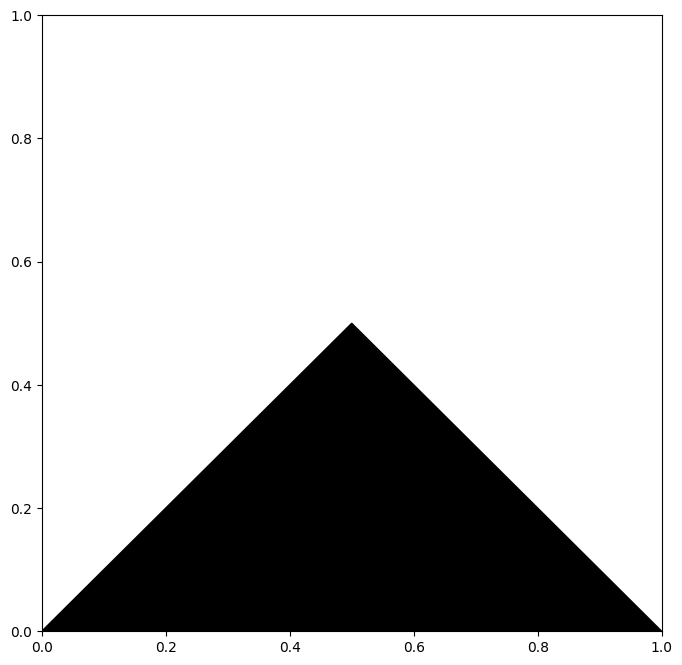

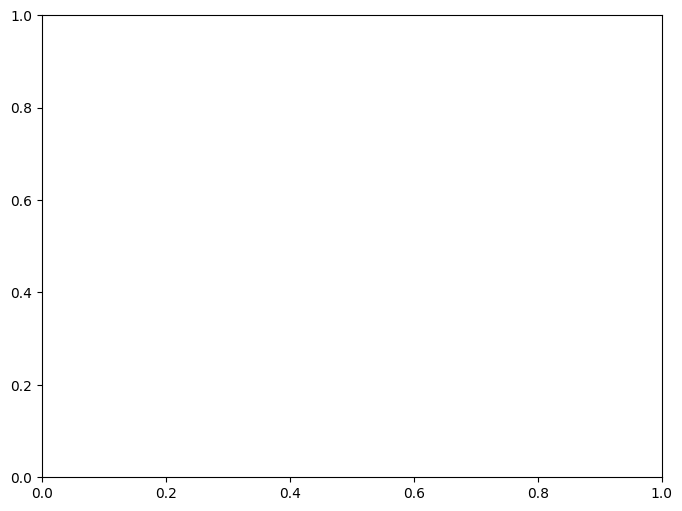

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Parâmetros da simulação
N = 1000  # Número inicial de partículas
d = 0.6e-3  # Diâmetro das partículas (m)
e = 0.9  # Coeficiente de restituição
m = 0.001  # Massa das partículas (kg)
k_B = 1.38e-23  # Constante de Boltzmann (J/K)
T_g = 300  # Temperatura inicial granular (K)
v_flux = 343  # Velocidade inicial do fluxo (Mach 1 ~ 343 m/s)
timesteps = 1000  # Número de passos de tempo
dt = 1e-4  # Intervalo de tempo (s)
L = 1  # Comprimento do domínio (m)
g = 9.81  # Aceleração gravitacional (m/s^2)
mu = -1.0  # Potencial químico (J)

# Inicialização das partículas
pos = np.random.rand(N, 2) * L  # Posições iniciais
vel = np.random.normal(0, np.sqrt(k_B * T_g / m), (N, 2)) + np.array([0, -v_flux])  # Velocidades iniciais

# Definição da cunha (triangular) invertida
cunha_pos = [L / 2, L / 2]
cunha_angle = np.pi / 4  # Ângulo da cunha (45 graus)

def checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle):
    x, y = pos.T
    x_cunha, y_cunha = cunha_pos
    normal = np.array([np.cos(cunha_angle), -np.sin(cunha_angle)])  # Cunha invertida
    rel_pos = pos - cunha_pos
    dist = np.dot(rel_pos, normal)
    colisao = dist < 0
    vel[colisao] = vel[colisao] - 2 * np.dot(vel[colisao], normal)[:, np.newaxis] * normal
    return vel

def inserir_remover_particulas(pos, vel, mu, T, V):
    # Probabilidades de inserção e remoção
    prob_inserir = np.exp(mu / (k_B * T))
    prob_remover = len(pos) / V
    if np.random.rand() < prob_inserir:
        nova_pos = np.random.rand(1, 2) * L
        nova_vel = np.random.normal(0, np.sqrt(k_B * T / m), (1, 2)) + np.array([0, -v_flux])
        pos = np.vstack([pos, nova_pos])
        vel = np.vstack([vel, nova_vel])
    elif np.random.rand() < prob_remover and len(pos) > 0:
        idx = np.random.randint(len(pos))
        pos = np.delete(pos, idx, axis=0)
        vel = np.delete(vel, idx, axis=0)
    return pos, vel

def simular_grancanonico(N, pos, vel, cunha_pos, cunha_angle, timesteps, dt, mu, T):
    posicoes = []
    temperaturas = []
    for t in range(timesteps):
        vel[:, 1] -= g * dt  # Adiciona gravidade
        pos += vel * dt
        vel = checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle)
        for i in range(len(pos)):
            for j in range(i + 1, len(pos)):
                if np.linalg.norm(pos[i] - pos[j]) < d:
                    v_i = vel[i]
                    v_j = vel[j]
                    vel[i] = (v_i + v_j) / 2 + e * (v_i - v_j) / 2
                    vel[j] = (v_i + v_j) / 2 - e * (v_i - v_j) / 2
        pos, vel = inserir_remover_particulas(pos, vel, mu, T, L**2)
        posicoes.append(pos.copy())
        T_g_calc = np.mean(np.linalg.norm(vel, axis=1) ** 2) * m / k_B
        temperaturas.append(T_g_calc)
    return posicoes, vel, temperaturas

posicoes, vel, temperaturas = simular_grancanonico(N, pos, vel, cunha_pos, cunha_angle, timesteps, dt, mu, T_g)

# Criação do GIF da simulação de partículas
fig, ax = plt.subplots(figsize=(8, 8))
cunha = plt.Polygon([[0.5, 0.5], [0, 0], [1, 0]], closed=True, color='black')
ax.add_patch(cunha)

def update_particles(frame):
    ax.clear()
    ax.add_patch(cunha)
    ax.scatter(posicoes[frame][:, 0], posicoes[frame][:, 1], s=1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    return ax

ani_particles = animation.FuncAnimation(fig, update_particles, frames=timesteps, interval=30)
ani_particles.save('simulacao_grancanonico_particulas.gif', writer='imagemagick')

# Criação do GIF da distribuição de velocidades
fig, ax = plt.subplots(figsize=(8, 6))

def update_vel(frame):
    ax.clear()
    v_bins = np.linspace(np.min(np.linalg.norm(vel, axis=1)), np.max(np.linalg.norm(vel, axis=1)), 100)
    pdf_v = (m / (2 * np.pi * k_B * temperaturas[frame])) ** 1.5 * np.exp(-m * v_bins ** 2 / (2 * k_B * temperaturas[frame]))
    ax.hist(np.linalg.norm(vel, axis=1), bins=100, density=True, alpha=0.6, color='g')
    ax.plot(v_bins, pdf_v, 'k-', lw=2)
    ax.set_title('Distribuição de Velocidades')
    ax.set_xlabel('Velocidade (m/s)')
    ax.set_ylabel('Densidade de Probabilidade')
    return ax

ani_vel = animation.FuncAnimation(fig, update_vel, frames=timesteps, interval=30)
ani_vel.save('distribuicao_grancanonico_velocidades.gif', writer='imagemagick')

# Criação do GIF do gradiente de temperatura
fig, ax = plt.subplots(figsize=(8, 6))

def update_temp(frame):
    ax.clear()
    T_bins = np.linspace(np.min(temperaturas), np.max(temperaturas), 100)
    pdf_T = (2 * np.pi * k_B * T_bins / m) ** -1.5 * np.exp(-k_B * T_bins / (2 * m))
    ax.hist(temperaturas, bins=100, density=True, alpha=0.6, color='r')
    ax.plot(T_bins, pdf_T, 'k-', lw=2)
    ax.set_title('Gradiente de Temperatura')
    ax.set_xlabel('Temperatura (K)')
    ax.set_ylabel('Densidade de Probabilidade')
    return ax

ani_temp = animation.FuncAnimation(fig, update_temp, frames=timesteps, interval=30)
ani_temp.save('gradiente_grancanonico_temperatura.gif', writer='imagemagick')

plt.show()


Sistema canonico

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Parâmetros da simulação
N = 1000  # Número de partículas
d = 0.6e-3  # Diâmetro das partículas (m)
e = 0.9  # Coeficiente de restituição
m = 0.001  # Massa das partículas (kg)
k_B = 1.38e-23  # Constante de Boltzmann (J/K)
T_g = 300  # Temperatura inicial granular (K)
v_flux = 343  # Velocidade inicial do fluxo (Mach 1 ~ 343 m/s)
timesteps = 1000  # Número de passos de tempo
dt = 1e-4  # Intervalo de tempo (s)
L = 1  # Comprimento do domínio (m)
g = 9.81  # Aceleração gravitacional (m/s^2)

# Inicialização das partículas
pos = np.random.rand(N, 2) * L  # Posições iniciais
vel = np.random.normal(0, np.sqrt(k_B * T_g / m), (N, 2)) + np.array([0, -v_flux])  # Velocidades iniciais

# Definição da cunha (triangular) invertida
cunha_pos = [L / 2, L / 2]
cunha_angle = np.pi / 4  # Ângulo da cunha (45 graus)

def checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle):
    x, y = pos.T
    x_cunha, y_cunha = cunha_pos
    normal = np.array([np.cos(cunha_angle), -np.sin(cunha_angle)])  # Cunha invertida
    rel_pos = pos - cunha_pos
    dist = np.dot(rel_pos, normal)
    colisao = dist < 0
    vel[colisao] = vel[colisao] - 2 * np.dot(vel[colisao], normal)[:, np.newaxis] * normal
    return vel

def simular_canonico(N, pos, vel, cunha_pos, cunha_angle, timesteps, dt):
    posicoes = []
    temperaturas = []
    for t in range(timesteps):
        vel[:, 1] -= g * dt  # Adiciona gravidade
        pos += vel * dt
        vel = checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle)
        for i in range(len(pos)):
            for j in range(i + 1, len(pos)):
                if np.linalg.norm(pos[i] - pos[j]) < d:
                    v_i = vel[i]
                    v_j = vel[j]
                    vel[i] = (v_i + v_j) / 2 + e * (v_i - v_j) / 2
                    vel[j] = (v_i + v_j) / 2 - e * (v_i - v_j) / 2
        posicoes.append(pos.copy())
        T_g_calc = np.mean(np.linalg.norm(vel, axis=1) ** 2) * m / k_B
        temperaturas.append(T_g_calc)
    return posicoes, vel, temperaturas

posicoes, vel, temperaturas = simular_canonico(N, pos, vel, cunha_pos, cunha_angle, timesteps, dt)

# Criação do GIF da simulação de partículas
fig, ax = plt.subplots(figsize=(8, 8))
cunha = plt.Polygon([[0.5, 0.5], [0, 0], [1, 0]], closed=True, color='black')
ax.add_patch(cunha)

def update_particles(frame):
    ax.clear()
    ax.add_patch(cunha)
    ax.scatter(posicoes[frame][:, 0], posicoes[frame][:, 1], s=1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    return ax

ani_particles = animation.FuncAnimation(fig, update_particles, frames=timesteps, interval=30)
ani_particles.save('simulacao_canonico_particulas.gif', writer='imagemagick')

# Criação do GIF da distribuição de velocidades
fig, ax = plt.subplots(figsize=(8, 6))

def update_vel(frame):
    ax.clear()
    v_bins = np.linspace(np.min(np.linalg.norm(vel, axis=1)), np.max(np.linalg.norm(vel, axis=1)), 100)
    pdf_v = (m / (2 * np.pi * k_B * temperaturas[frame])) ** 1.5 * np.exp(-m * v_bins ** 2 / (2 * k_B * temperaturas[frame]))
    ax.hist(np.linalg.norm(vel, axis=1), bins=100, density=True, alpha=0.6, color='g')
    ax.plot(v_bins, pdf_v, 'k-', lw=2)
    ax.set_title('Distribuição de Velocidades')
    ax.set_xlabel('Velocidade (m/s)')
    ax.set_ylabel('Densidade de Probabilidade')
    return ax

ani_vel = animation.FuncAnimation(fig, update_vel, frames=timesteps, interval=30)
ani_vel.save('distribuicao_canonico_velocidades.gif', writer='imagemagick')

# Criação do GIF do gradiente de temperatura
fig, ax = plt.subplots(figsize=(8, 6))

def update_temp(frame):
    ax.clear()
    T_bins = np.linspace(np.min(temperaturas), np.max(temperaturas), 100)
    pdf_T = (2 * np.pi * k_B * T_bins / m) ** -1.5 * np.exp(-k_B * T_bins / (2 * m))
    ax.hist(temperaturas, bins=100, density=True, alpha=0.6, color='r')
    ax.plot(T_bins, pdf_T, 'k-', lw=2)
    ax.set_title('Gradiente de Temperatura')
    ax.set_xlabel('Temperatura (K)')
    ax.set_ylabel('Densidade de Probabilidade')
    return ax

ani_temp = animation.FuncAnimation(fig, update_temp, frames=timesteps, interval=30)
ani_temp.save('gradiente_canonico_temperatura.gif', writer='imagemagick')

plt.show()


KeyboardInterrupt: 

sistema canonico isotermico ajustado

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Parâmetros da simulação
N = 1000  # Número de partículas
d = 0.6e-3  # Diâmetro das partículas (m)
e = 0.9  # Coeficiente de restituição
m = 0.001  # Massa das partículas (kg)
k_B = 1.38e-23  # Constante de Boltzmann (J/K)
T_g = 300  # Temperatura desejada (K)
v_flux = 343  # Velocidade inicial do fluxo (Mach 1 ~ 343 m/s)
timesteps = 100  # Número de passos de tempo
dt = 1e-4  # Intervalo de tempo (s)
L = 1  # Comprimento do domínio (m)
g = 9.81  # Aceleração gravitacional (m/s^2)
tau = 0.1  # Constante de tempo do termostato

# Inicialização das partículas
pos = np.random.rand(N, 2) * L  # Posições iniciais
vel = np.random.normal(0, np.sqrt(k_B * T_g / m), (N, 2)) + np.array([0, -v_flux])  # Velocidades iniciais

# Definição da cunha (triangular) invertida
cunha_pos = [L / 2, L / 2]
cunha_angle = np.pi / 4  # Ângulo da cunha (45 graus)

def checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle):
    x, y = pos.T
    x_cunha, y_cunha = cunha_pos
    normal = np.array([np.cos(cunha_angle), -np.sin(cunha_angle)])  # Cunha invertida
    rel_pos = pos - cunha_pos
    dist = np.dot(rel_pos, normal)
    colisao = dist < 0
    vel[colisao] = vel[colisao] - 2 * np.dot(vel[colisao], normal)[:, np.newaxis] * normal
    return vel

def aplicar_termotato(vel, T_g, tau, dt):
    T_actual = np.mean(np.linalg.norm(vel, axis=1) ** 2) * m / k_B
    lambda_t = np.sqrt(1 + dt / tau * (T_g / T_actual - 1))
    vel *= lambda_t
    return vel

def simular_isotermico(N, pos, vel, cunha_pos, cunha_angle, timesteps, dt, T_g, tau):
    posicoes = []
    temperaturas = []
    for t in range(timesteps):
        vel[:, 1] -= g * dt  # Adiciona gravidade
        pos += vel * dt
        vel = checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle)
        for i in range(len(pos)):
            for j in range(i + 1, len(pos)):
                if np.linalg.norm(pos[i] - pos[j]) < d:
                    v_i = vel[i]
                    v_j = vel[j]
                    vel[i] = (v_i + v_j) / 2 + e * (v_i - v_j) / 2
                    vel[j] = (v_i + v_j) / 2 - e * (v_i - v_j) / 2
        vel = aplicar_termotato(vel, T_g, tau, dt)
        posicoes.append(pos.copy())
        T_g_calc = np.mean(np.linalg.norm(vel, axis=1) ** 2) * m / k_B
        temperaturas.append(T_g_calc)
    return posicoes, vel, temperaturas

posicoes, vel, temperaturas = simular_isotermico(N, pos, vel, cunha_pos, cunha_angle, timesteps, dt, T_g, tau)

# Criação do GIF da simulação de partículas
fig, ax = plt.subplots(figsize=(8, 8))
cunha = plt.Polygon([[0.5, 0.5], [0, 0], [1, 0]], closed=True, color='black')
ax.add_patch(cunha)

def update_particles(frame):
    ax.clear()
    ax.add_patch(cunha)
    ax.scatter(posicoes[frame][:, 0], posicoes[frame][:, 1], s=1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    return ax

ani_particles = animation.FuncAnimation(fig, update_particles, frames=timesteps, interval=30)
ani_particles.save('simulacao_isotermico_particulas.gif', writer='imagemagick')

# Criação do GIF da distribuição de velocidades
fig, ax = plt.subplots(figsize=(8, 6))

def update_vel(frame):
    ax.clear()
    v_bins = np.linspace(np.min(np.linalg.norm(vel, axis=1)), np.max(np.linalg.norm(vel, axis=1)), 100)
    pdf_v = (m / (2 * np.pi * k_B * temperaturas[frame])) ** 1.5 * np.exp(-m * v_bins ** 2 / (2 * k_B * temperaturas[frame]))
    ax.hist(np.linalg.norm(vel, axis=1), bins=100, density=True, alpha=0.6, color='g')
    ax.plot(v_bins, pdf_v, 'k-', lw=2)
    ax.set_title('Distribuição de Velocidades')
    ax.set_xlabel('Velocidade (m/s)')
    ax.set_ylabel('Densidade de Probabilidade')
    return ax

ani_vel = animation.FuncAnimation(fig, update_vel, frames=timesteps, interval=30)
ani_vel.save('distribuicao_isotermico_velocidades.gif', writer='imagemagick')

# Criação do GIF do gradiente de temperatura
fig, ax = plt.subplots(figsize=(8, 6))

def update_temp(frame):
    ax.clear()
    T_bins = np.linspace(np.min(temperaturas), np.max(temperaturas), 100)
    pdf_T = (2 * np.pi * k_B * T_bins / m) ** -1.5 * np.exp(-k_B * T_bins / (2 * m))
    ax.hist(temperaturas, bins=100, density=True, alpha=0.6, color='r')
    ax.plot(T_bins, pdf_T, 'k-', lw=2)
    ax.set_title('Gradiente de Temperatura')
    ax.set_xlabel('Temperatura (K)')
    ax.set_ylabel('Densidade de Probabilidade')
    return ax

ani_temp = animation.FuncAnimation(fig, update_temp, frames=timesteps, interval=30)
ani_temp.save('gradiente_isotermico_temperatura.gif', writer='imagemagick')

plt.show()


Equação de naiver-stokes

In [ ]:
!pip install FEniCS

In [ ]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

# Parâmetros da simulação
L = 1.0  # Comprimento do domínio (m)
N = 50  # Número de células na malha
T = 2.0  # Tempo total de simulação
num_steps = 100  # Número de passos de tempo
dt = T / num_steps  # Intervalo de tempo

# Parâmetros físicos
rho = 1.0  # Densidade (kg/m^3)
mu = 0.001  # Viscosidade dinâmica (Pa.s)
g = 9.81  # Aceleração da gravidade (m/s^2)

# Malha e espaço de função
mesh = UnitSquareMesh(N, N)
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

# Condições de contorno
inflow = 'near(x[0], 0)'
outflow = 'near(x[0], 1)'
walls = 'near(x[1], 0) || near(x[1], 1)'
bc_inflow = DirichletBC(V, Constant((1, 0)), inflow)
bc_walls = DirichletBC(V, Constant((0, 0)), walls)
bc_outflow = DirichletBC(Q, Constant(0), outflow)
bcs = [bc_inflow, bc_walls]

# Funções variáveis e testadoras
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

# Condições iniciais
u_n = Function(V)
u_ = Function(V)
p_n = Function(Q)
p_ = Function(Q)

# Formulação fraca das equações de Navier-Stokes
U = 0.5*(u_n + u)
f = Constant((0, -rho*g))
F1 = rho*dot((u - u_n) / dt, v)*dx + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx + mu*inner(grad(u), grad(v))*dx - dot(f, v)*dx
a1, L1 = lhs(F1), rhs(F1)

F2 = dot(grad(p), grad(q))*dx - rho*div(u_)*q*dx
a2, L2 = lhs(F2), rhs(F2)

F3 = dot(u, v)*dx - dot(u_, v)*dx + dt*dot(grad(p_ - p_n), v)*dx
a3, L3 = lhs(F3), rhs(F3)

# Malha e espaço de função para partículas
mesh_particles = UnitSquareMesh(N, N)
V_particles = FunctionSpace(mesh_particles, 'P', 1)
particles = project(Expression(('x[0]', 'x[1]'), degree=1), V_particles)

# Diretório para salvar os gráficos
output_dir = "simulation_outputs"
os.makedirs(output_dir, exist_ok=True)
image_files = []

# Simulação
for n in range(num_steps):
    # Resolver o problema de Stokes
    solve(a1 == L1, u_, bcs)
    solve(a2 == L2, p_)
    solve(a3 == L3, u_)

    # Atualizar a condição inicial
    u_n.assign(u_)
    p_n.assign(p_)

    # Plotar e salvar o resultado
    plt.figure(figsize=(8, 6))
    plot(u_, title=f"Velocidade no tempo {n*dt:.2f}s")
    filename = f"{output_dir}/frame_{n:03d}.png"
    plt.savefig(filename)
    image_files.append(filename)
    plt.close()

# Criar o GIF
gif_filename = "simulation_results.gif"
with imageio.get_writer(gif_filename, mode='I', duration=0.1) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)

# Converter GIF para MP4 usando imageio_ffmpeg
mp4_filename = "simulation_results.mp4"
import imageio_ffmpeg as ffmpeg

cmd = ffmpeg.get_ffmpeg_exe() + f" -i {gif_filename} {mp4_filename}"
os.system(cmd)

print(f"MP4 gerado: {mp4_filename}")


ModuleNotFoundError: No module named 'fenics'